### Übungsblatt 7 - Rubin Mehralivand, Luis Schneck

In [241]:
import numpy as np
import matplotlib.pyplot as plt

In [242]:
def f(t: float, z: np.ndarray) -> np.ndarray:
    r = np.ndarray(3)
    r[0] = -0.4 * z[0] + z[1] * z[2]
    r[1] = 0.4 * z[0] - z[1] * z[2] - 3 * z[2]**2
    r[2] = 3 * z[2]**2
    return r

In [243]:
# RK4-Methode
A = np.array([
    [0, 0],
    [0.5, 0],
])
b = np.array([0, 1])
c = np.array([0, 0.5])
initialwert = np.array([1, 0, 0])

Für die Schrittweitensteuerung schreiben wir unsere originale 2-stufige RK-Funktion aus dem letzten Übungsblatt um in eine Schrittfunktion. Als Interface nutzen wir die Funktion adaptive_rk. <br>
Zur Schrittweitensteuerung setzen wir erst $H = 2h_n$ und probeweise $t_{n+1} = t_n + H$. Danach werten wir $y_{n+1}^H$ und $y_{n+1}^{H/2}$ aus und berechnen den Abschneidefehler:
$$\tilde{\tau}_{n+1}^{(2)} = \frac{y_{n+1}^H - y_{n+1}^{H/2}}{H^{3}(1-2^{-2})}$$
Die daraus resultierende Schrittweite ist:
$$h_{n+1} = \left(\frac{TOL}{||\tilde{\tau}^{(2)}_{n+1}||}\right)^{1/m}$$
Danach werden die Bedingungen aus dem Algorithmus im Skript getestet, die neuen Schrittweiten gesetzt, geloggt und weitergerechnet.

TOL: 0.01 	 Stepsize Reduction: 0.127 	 Error Calculations: 8 	 Error at T: 0.004078876544169974

TOL: 0.001 	 Stepsize Reduction: 0.127 	 Error Calculations: 8 	 Error at T: 0.004078876544169974

TOL: 0.0001 	 Stepsize Reduction: 0.127 	 Error Calculations: 8 	 Error at T: 0.004078876544169974

TOL: 1e-05 	 Stepsize Reduction: 0.127 	 Error Calculations: 8 	 Error at T: 0.004078876544169974

TOL: 1e-06 	 Stepsize Reduction: 0.127 	 Error Calculations: 8 	 Error at T: 0.004078876544169974

TOL: 1e-07 	 Stepsize Reduction: 0.127 	 Error Calculations: 8 	 Error at T: 0.004078876544169974

TOL: 1e-08 	 Stepsize Reduction: 0.127 	 Error Calculations: 8 	 Error at T: 0.004078876544169974

TOL: 1e-09 	 Stepsize Reduction: 0.08696561900051944 	 Error Calculations: 10 	 Error at T: 0.004073245867825497



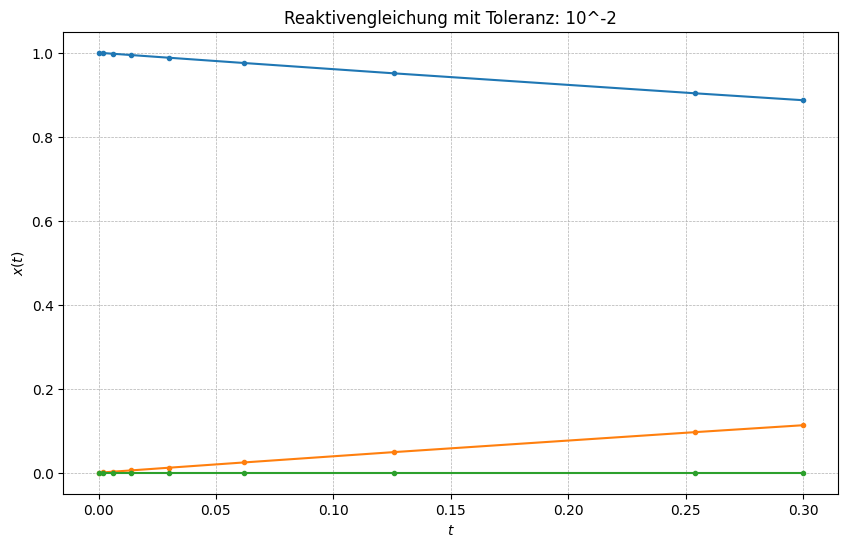

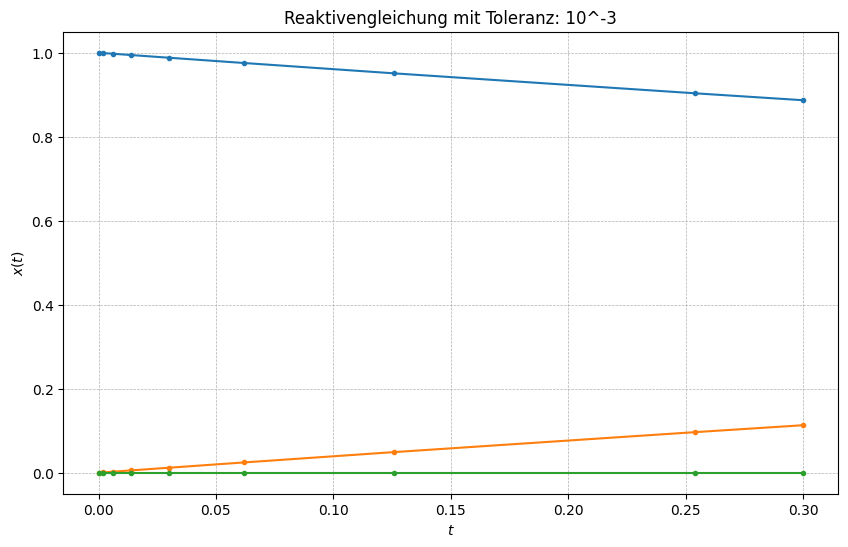

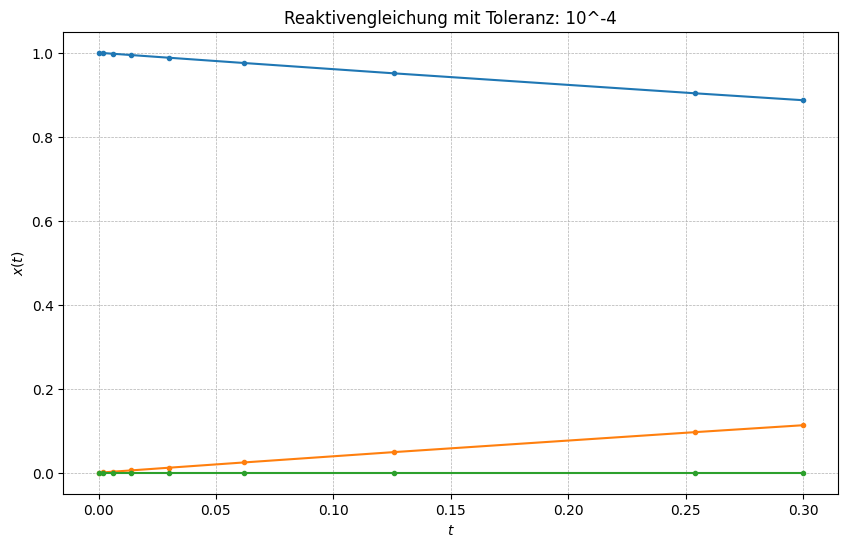

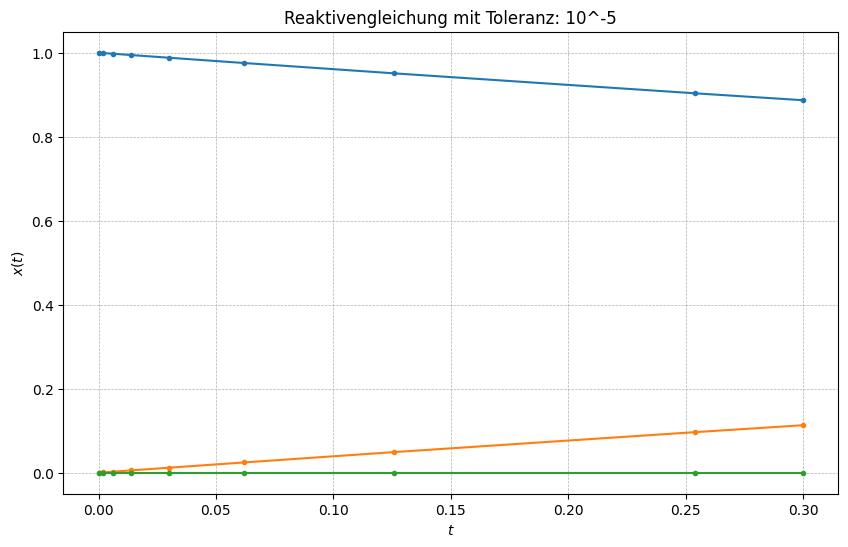

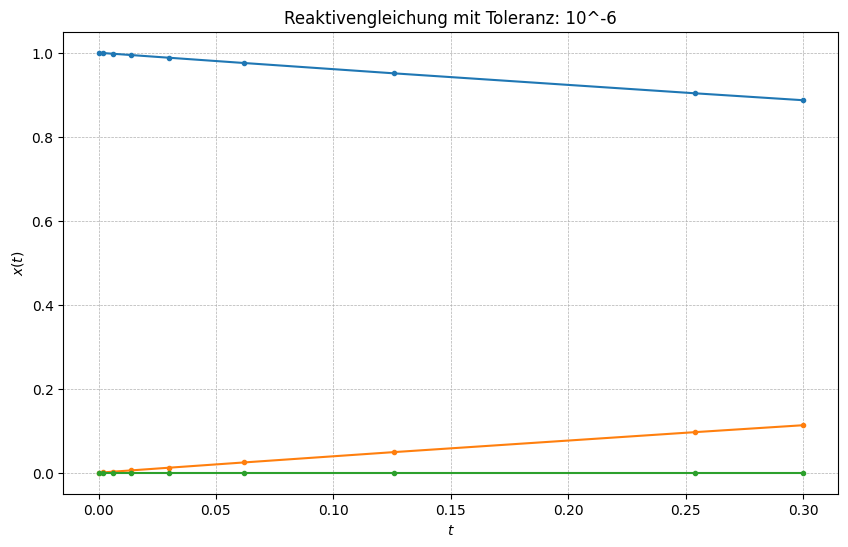

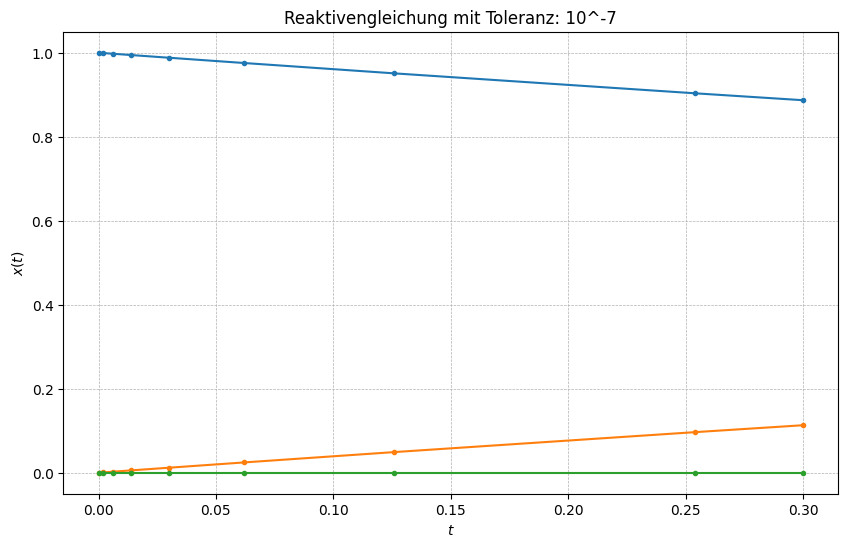

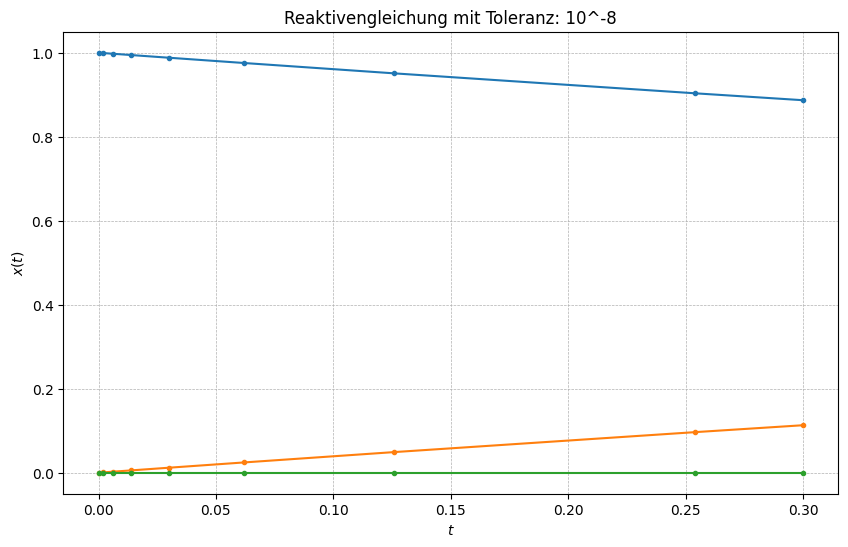

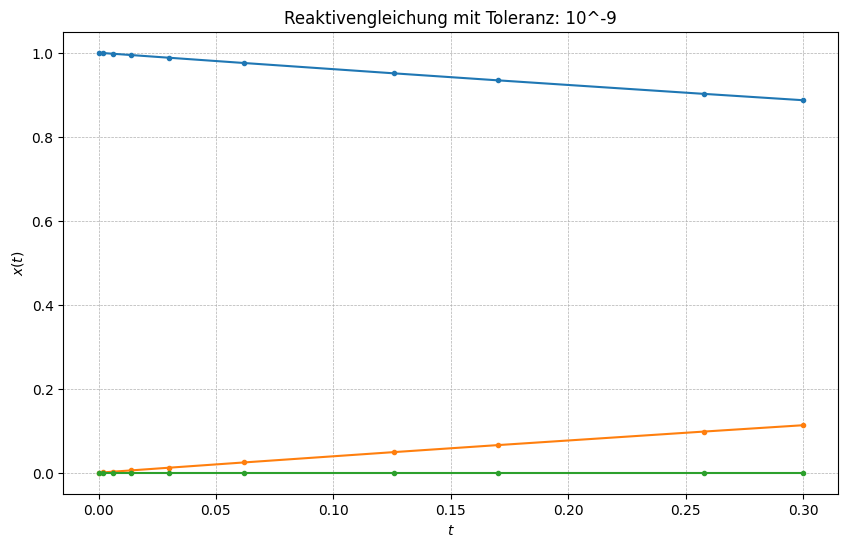

In [244]:
def runge_kutta(f: callable, t: float, y: np.ndarray, h: float, A: np.array, b: np.array, c: np.array) -> np.ndarray:
    # Umgeschriebenes RK-Verfahren für einen Schritt
    s = A.shape[0]

    k = np.zeros((s,len(initialwert)))

    for i in range (0, s):
        k[i] = f(t + c[i] * h, y + h * A[i, :] @ k[:])

    y = y + h * b[:] @ k[:]

    return y


def step_size_control(f: callable, h: float, t: float, t_end: float, y: np.array, tol: float) -> tuple:
    tau = 0
    n = 0

    while True:
        H = 2*h
        y_H = runge_kutta(f, t, y, H, A, b, c)
        y_Half = runge_kutta(f, t, y, H/2, A, b, c)
        y_Half = runge_kutta(f, t + H/2, y_Half, H/2, A, b, c)

        n += 1
        tau = np.linalg.norm(y_Half - y_H)/(H**3 * (1 - 2**-2)) # Berechnung Abschneidefehler
        h_new = (tol/(t_end * tau))**(1/4)  # Berechnung neue Schrittweite

        if h_new <= (0.25*H):
            if H < np.finfo(float).eps:
                print('Fehler zu groß, Schrittweite anders wählen.')
                break
            h = h_new
            continue
        break

    return H, y_Half, y_H, np.linalg.norm(tau), n


def adaptive_rk(f: callable, y0: np.ndarray, t0: float, t_end: float, h0: float, tol: float):
    t = t0
    y = y0
    h = h0
    n = 0

    SR = np.array([h])  # Schrittweiten-Logging
    E = np.array([0])   # Fehler (angenommen ungestörte Anfangswerte)
    T = np.array([t])   # Zeitschritte t + h
    Y = np.array([y])   # Auswertungen

    while t < t_end:
        h = min(h, (t_end-t)/2) # Falls t + h > T setze h auf das Intervallende ( /2 wegen H = 2*h )
        H, y_Half,y_H, tau, steps = step_size_control(f, h, t, t_end, y, tol)
        n += steps  # Schrittzahl-Logging

        h = H
        t += H
        y = (2**2 * y_Half - y_H)/(2**2 - 1)    # Extrapolation zum Limes für bessere Näherung

        SR = np.append(SR, h)
        E = np.append(E, tau)
        T = np.append(T, t)
        Y = np.append(Y, [y], axis=0)

    return T, Y, 0.3*E[-1], np.abs(max(SR)-min(SR)), n


for k in range(2, 10):
    t, z, error, stepsize_red, steps = adaptive_rk(f, initialwert, 0, 0.3, 0.001, 10**-k)   # Man kann den Intervall auch größer wählen und mal nachschauen
    print(f"TOL: {10**-k} \t Stepsize Reduction: {stepsize_red} \t Error Calculations: {steps} \t Error at T: {error}")
    print()
    plt.figure(figsize=(10, 6))
    plt.plot(t, z[:,0], marker='.', label='$x_1(t)$')
    plt.plot(t, z[:,1], marker='.', label='$x_2(t)$')
    plt.plot(t, z[:,2], marker='.', label='$x_3(t)$')
    plt.xlabel("$t$")
    plt.ylabel("$x(t)$")
    #plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.title(f"Reaktivengleichung mit Toleranz: 10^-{k}")

plt.show()
